In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


CUDA_VISIBLE_DEVICES: 4 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [2]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud, Loud Tour}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

In [3]:
df = df_raw.copy()
df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
df = df[df["evidence_sents"].str.len() == 1]  # 1 Evidence Sentence
df = df[df["head_entity_in_evidence"].str.len() == 1]  # 1 Head in Evidence
df = df[df["head_entity"].str.len() >= 2]  # Another head in other sentence (2239 --> 420)
df = df[df["head_entity_names"].str.len() == 1]  # All heads have the same name
df = df[df["tail_entity_names"].str.len() == 1]  # All tails have the same name
# df = df[df["tail_entity"].str.len() == 1]  # 1 Mention of the Tail in Doc
# df = df.drop_duplicates(subset=["query"], keep="first")
# Filter Repeated Labels (Only 1 h->t)
def not_repeated_label(label, labels):
    repeat_count = 0
    for l in labels:
        if (l['h'] == label['h'] and l['t'] == label['t']) or (l['h'] == label['t'] or l['t'] == label['t']):  # or (l['h'] == label['h'] and l['r'] == label['r'])
            repeat_count += 1
    return True if repeat_count == 1 else False
df["repeated_label"] = df.apply(lambda r: not_repeated_label(r["label"], r["labels"]), axis=1)
# df = df[df["repeated_label"]]
# df = df[df["head_entity"].str.len() == 2]  # 2 Head Entity (1 in evidence, 1 not in evidence)
print(len(df))  # 2239

def flatten(xss):
    return [x for xs in xss for x in xs]

def sentences_w_multiple_heads(head_enitites):
    sents = []
    repeated = []
    for e in head_enitites:
        sents.append(e["sent_id"])
        if sents.count(e["sent_id"]) > 1:
            repeated.append(e["sent_id"])
    return list(set(repeated))

def has_similar_label_to_tail(sent_id, row):
    for label in row["labels"]:
        # if head_entity['sent_id'] in label['evidence'] and ((label["r"] == row["label"]["r"] and label["h"] == row["label"]["h"]) or label["t"] == row["label"]["t"] or label["h"] == row["label"]["t"]):
        if sent_id in label['evidence'] and (label["r"] == row["label"]["r"] or label["t"] == row["label"]["t"] or label["h"] == row["label"]["t"]):    
            return True
        if row["tail_entity"][0]["name"] in " ".join(row["sents"][sent_id]):
            return True
    return False

### Find Head in other sentences
head_w_tail_sents = []
head_wo_tail_sents = []
head_wo_tail_entity = []
for row in df.to_dict(orient="records"):
    head_w_tail = " ".join(flatten(row["evidence_sents"]))
    head_wo_tail = None
    sents_w_multiple_heads = sentences_w_multiple_heads(row["head_entity"])
    for head_entity in row["head_entity"]:
        evidence_sent_id = row["evidence_sent_ids"][0]
        if head_entity["sent_id"] != evidence_sent_id and head_entity["sent_id"] not in sents_w_multiple_heads:
            if not has_similar_label_to_tail(head_entity['sent_id'], row):
                head_wo_tail_ent = head_entity
                head_wo_tail = " ".join(row["sents"][head_entity["sent_id"]])
                break
    if head_wo_tail is None:
        head_w_tail_sents.append(None)
        head_wo_tail_sents.append(None)
        head_wo_tail_entity.append(None)
    else:
        head_w_tail_sents.append(head_w_tail)
        head_wo_tail_sents.append(head_wo_tail)
        head_wo_tail_entity.append(head_wo_tail_ent)
    
df["head_w_tail_sentence"] = head_w_tail_sents
df["head_wo_tail_sentence"] = head_wo_tail_sents
df["head_wo_tail_entity"] = head_wo_tail_entity
df = df.dropna(subset=["head_w_tail_sentence", "head_wo_tail_sentence"])
# df = df.drop_duplicates(subset=["query"], keep="first")
print(len(df))

### FILTER NOT SAME POS ENTITY {
# df["head_wo_tail_entity_pos"] = df["head_wo_tail_entity"].apply(lambda x: x["pos"][0])
# df["head_w_tail_entity_pos"] = df["head_entity_in_evidence"].apply(lambda x: x[0]["pos"][0])
# df = df[df["head_wo_tail_entity_pos"] == df["head_w_tail_entity_pos"]]
# print(len(df))
### }

df["head_wo_tail_sentence_double"] = df["head_wo_tail_sentence"] + " " + df["head_wo_tail_sentence"]
df["head_w_tail_sentence_double"] = df["head_w_tail_sentence"] + " " + df["head_w_tail_sentence"]
df["head_wo_tail_sentence_title"] = df.apply(lambda r: r["head_entity_in_evidence"][0]["name"] + " " + r["head_entity_in_evidence"][0]["name"] + " " + r["head_entity_in_evidence"][0]["name"] + " " + r["head_wo_tail_sentence"], axis=1)

df["head_entity_sent_ids"] = df["head_entity"].apply(lambda hs: [h["sent_id"] for h in hs])
# df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))
df["sents_complete"] = df.apply(lambda r: " ".join(flatten([s for sent_id, s in enumerate(r["sents"]) if (not has_similar_label_to_tail(sent_id, r)) & sent_id not in r["head_entity_sent_ids"] ])), axis=1)


df["sents_complete_rm_head_wo_tail"] = df.apply(lambda r: r["sents_complete"].replace(r["head_wo_tail_sentence"], ""), axis=1)
df["sents_complete_rm_head_w_tail"] = df.apply(lambda r: r["sents_complete"].replace(r["head_w_tail_sentence"], ""), axis=1)
# Put the w and wo sentence in the beginning
df["sents_complete_w_beginning"] = df.apply(lambda r: r["head_w_tail_sentence"] + " " + r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], ""), axis=1)
df["sents_complete_wo_beginning"] = df.apply(lambda r: r["head_wo_tail_sentence"] + " " + r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], ""), axis=1)
# Put the w and wo sentence in the end
df["sents_complete_w_end"] = df.apply(lambda r: r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], "") + " " + r["head_w_tail_sentence"] , axis=1)
df["sents_complete_wo_end"] = df.apply(lambda r: r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], "") + " " + r["head_wo_tail_sentence"], axis=1)

df["tail_count"] = df.apply(lambda r: r["sents_complete_rm_head_w_tail"].count(r["tail_entity"][0]["name"]), axis=1)
df = df[df["tail_count"] == 0]
print(len(df))

df = df.groupby('query').tail(2)
df = df.groupby('title').tail(3)
print(len(df))

df = df.sample(250, random_state=0)
print(len(df))

df_raw2 = df_raw.copy()
df_raw2["sents_len"] = df_raw2["sents"].apply(lambda x: len(x))
df_raw2["beginning_relations"] = df_raw2["labels"].apply(lambda x: " ".join([xi["r"] for xi in x if len(xi["evidence"]) > 0 and min(xi["evidence"]) in [0, 1]]))
df_raw2["beginning_entity_types"] = df_raw2["vertexSet"].apply(lambda x: " ".join([xi[0]["type"] for xi in x if min([xii["sent_id"] for xii in xi]) in [0, 1]]))
df_raw2 = df_raw2[df_raw2["sents_len"] > 3]  # 8
df_raw2 = df_raw2.drop_duplicates(subset=["title"], keep="first")
print(len(df_raw2), "raw2")

df_raw2["gold_doc_text_n"] = df_raw2.apply(lambda r: " ".join(flatten([s for sent_id, s in enumerate(r["sents"][0:4])])), axis=1)
df_raw2["gold_doc_text_n_2"] = df_raw2.apply(lambda r: " ".join(flatten([s for sent_id, s in enumerate(r["sents"][4:8])])), axis=1)
df["foil_random_sents"] = df.apply(lambda r: df_raw2[(df_raw2["title"] != r["title"]) & ~(df_raw2["beginning_relations"].str.contains(r["label"]["r"])) & ~(df_raw2["beginning_entity_types"].str.contains(list(r["tail_entity_types"])[0]))].sample(1, random_state=r.name+0)["gold_doc_text_n"].values[0], axis=1)
df["foil_random_sents_2"] = df.apply(lambda r: df_raw2[(df_raw2["title"] != r["title"]) & ~(df_raw2["beginning_relations"].str.contains(r["label"]["r"])) & ~(df_raw2["beginning_entity_types"].str.contains(list(r["tail_entity_types"])[0]))].sample(1, random_state=r.name+0)["gold_doc_text_n_2"].values[0], axis=1)

df["sents_complete_w_foil"] =  df.apply(lambda r: r["foil_random_sents"] + " " + r["head_w_tail_sentence"] + " " + r["foil_random_sents"], axis=1)
df["sents_complete_wo_foil"] = df.apply(lambda r: ('" ' + r["head_entity_longest_name"] + ' " ') * 2 + r["head_wo_tail_sentence"], axis=1)

sents_cols = []
sents_cols.append(f"sents_complete_w_foil")
sents_cols.append(f"sents_complete_wo_foil")

print(df["title"].value_counts().value_counts())

save_cols = [
    "query", "gold_docs", "gold_docs_text", "scores_stats", "scores_gold", "predicted_docs_text_10", "id", "title", "vertexSet", 
    "labels", "sents", "split", "label", "label_idx", "head_entity", 
    "tail_entity", "head_entity_names", "tail_entity_names", 
    "head_entity_longest_name", "tail_entity_longest_name", 
    "head_entity_types", "tail_entity_types", "evidence_sent_ids", 
    "evidence_sents", "head_entity_in_evidence", "tail_entity_in_evidence", 
    "relation", "relation_name", "query_question", "duplicate_titles_len", 
    "duplicate_titles", "hit_rank", "gold_doc", "gold_doc_title", 
    "gold_doc_text", "gold_doc_score", "pred_doc", "pred_doc_title", 
    "pred_doc_text", "pred_doc_score", "gold_doc_len", "pred_doc_len",
] + sents_cols
df[save_cols].to_json("dataset/foil.jsonl", orient="records", lines=True)

# df[["query", "head_w_tail_sentence", "head_wo_tail_sentence", "head_entity_in_evidence", "head_wo_tail_entity", "sents_complete", "sents_complete_rm_head_wo_tail", "sents_complete_rm_head_w_tail"]].sample(3)
pd.set_option('display.max_colwidth', 100)
df[sents_cols + ["query", "title", "tail_entity_longest_name"]].sort_values("title")

377
273
266
250
250
929 raw2
count
1    81
2    41
3    29
Name: count, dtype: int64


,sents_complete_w_foil,sents_complete_wo_foil,query,title,tail_entity_longest_name
1396,"The Navy , Army and Air Force Institutes ( NAAFI ) is an organisation created by the British gov...",""" Be Still My Beating Heart "" "" Be Still My Beating Heart "" In 1989 the album received three Gra...",What precedes Be Still My Beating Heart?,...Nothing Like the Sun,We 'll Be Together
1397,Ooredoo QSC (; formerly Qtel ) is an international telecommunications company headquartered in D...,""" Be Still My Beating Heart "" "" Be Still My Beating Heart "" In 1989 the album received three Gra...",What follows Be Still My Beating Heart?,...Nothing Like the Sun,Englishman in New York
1398,"Woodlawn is an unincorporated community and census - designated place in Baltimore County , Mary...",""" Be Still My Beating Heart "" "" Be Still My Beating Heart "" In 1989 the album received three Gra...",What precedes Be Still My Beating Heart?,...Nothing Like the Sun,Englishman in New York
4370,"Bound Brook is a tributary of the Raritan River in Middlesex County , New Jersey , in the United...",""" ABBA Live "" "" ABBA Live "" The resultant album , ABBA Live , contained recordings from 1977 , 1...",Which record label is ABBA Live associated with?,ABBA Live,Polar Music
4371,The following outline is provided as an overview of and topical guide to South Sudan : South Sud...,""" ABBA Live "" "" ABBA Live "" The resultant album , ABBA Live , contained recordings from 1977 , 1...",When was ABBA Live published?,ABBA Live,1986
...,...,...,...,...,...
6586,"Between Five and Seven is as the name suggests , the sixth studio album by folk singer - songwri...",""" Yandina "" "" Yandina "" Yandina is the site of a copra and cocoa plantation and has basic servic...",Where is Yandina located on a terrain feature?,"Yandina, Solomon Islands",Mbanika Island
4213,"The Vätsäri Wilderness Area ( , ) is located along the northeastern shore of Lake Inari in Inari...",""" Your Disco Needs You "" "" Your Disco Needs You "" Lyrically , "" Your Disco Needs You "" talks abo...",What is Your Disco Needs You a part of?,Your Disco Needs You,Light Years
4214,"Orangina ( ) is a lightly carbonated beverage made from carbonated water , 12 % citrus juice , (...",""" Your Disco Needs You "" "" Your Disco Needs You "" Lyrically , "" Your Disco Needs You "" talks abo...",When was Your Disco Needs You published?,Your Disco Needs You,2000
3555,Antisemitic canards are unfounded rumors or false allegations which are defamatory towards Judai...,""" Balash "" "" Balash "" Balash was thus forced to make peace with his enemy Vahan Mamikonian and s...",Who is the sibling of Balash?,Zarir,Peroz I.


In [4]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", verbose=True, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.verbose = verbose
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False), disable=not self.verbose):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        if self.verbose: print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

In [5]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df['query'].to_list())
    for sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot = df.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/dragon-roberta-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/contriever-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/contriever:   0%|          | 0/2 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/2 [00:00<?, ?it/s]

['facebook/dragon-plus-query-encoder_sents_complete_w_foil_dot', 'facebook/dragon-plus-query-encoder_sents_complete_wo_foil_dot', 'facebook/dragon-roberta-query-encoder_sents_complete_w_foil_dot', 'facebook/dragon-roberta-query-encoder_sents_complete_wo_foil_dot', 'facebook/contriever-msmarco_sents_complete_w_foil_dot', 'facebook/contriever-msmarco_sents_complete_wo_foil_dot', 'facebook/contriever_sents_complete_w_foil_dot', 'facebook/contriever_sents_complete_wo_foil_dot', 'OpenMatch/cocodr-base-msmarco_sents_complete_w_foil_dot', 'OpenMatch/cocodr-base-msmarco_sents_complete_wo_foil_dot', 'Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_foil_dot', 'Shitao/RetroMAE_MSMARCO_finetune_sents_complete_wo_foil_dot']


  0%|          | 0/6 [00:00<?, ?it/s]

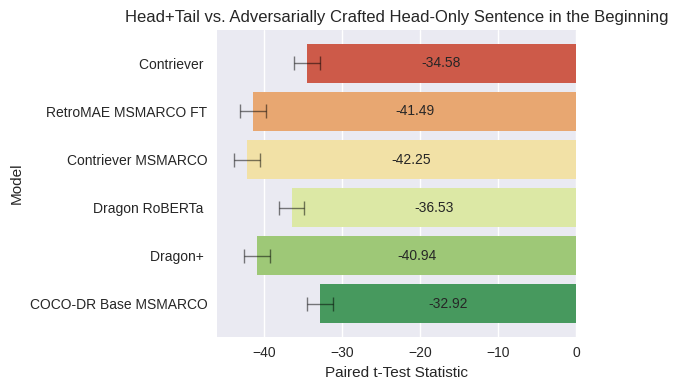

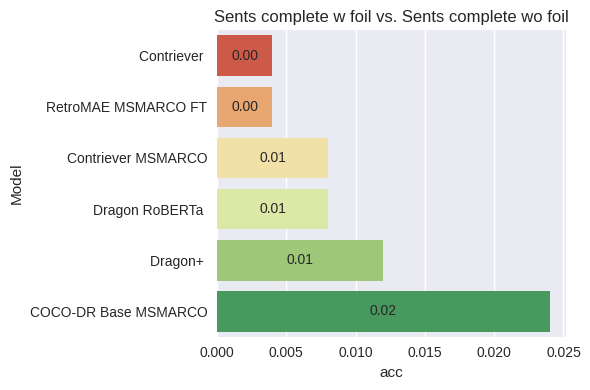

,Model,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low_stats,ttest_ci_high_stats,ttest_ci_low,ttest_ci_high,standard_ttest_ppf,acc
0,Contriever,facebook/contriever_sents_complete_w_foil_dot,facebook/contriever_sents_complete_wo_foil_dot,-34.584362,4.618081e-97,-0.343422,-0.306414,1.650996,1.650996,-1.650996,0.004
0,RetroMAE MSMARCO FT,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_foil_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_wo_foil_dot,-41.491912,7.627458e-114,-13.229835,-12.030766,1.650996,1.650996,-1.650996,0.004
0,Contriever MSMARCO,facebook/contriever-msmarco_sents_complete_w_foil_dot,facebook/contriever-msmarco_sents_complete_wo_foil_dot,-42.247342,1.489215e-115,-0.650481,-0.592533,1.650996,1.650996,-1.650996,0.008
0,Dragon RoBERTa,facebook/dragon-roberta-query-encoder_sents_complete_w_foil_dot,facebook/dragon-roberta-query-encoder_sents_complete_wo_foil_dot,-36.531740,5.155568e-102,-10.895163,-9.780477,1.650996,1.650996,-1.650996,0.008
0,Dragon+,facebook/dragon-plus-query-encoder_sents_complete_w_foil_dot,facebook/dragon-plus-query-encoder_sents_complete_wo_foil_dot,-40.935914,1.430444e-112,-11.925786,-10.830901,1.650996,1.650996,-1.650996,0.012
0,COCO-DR Base MSMARCO,OpenMatch/cocodr-base-msmarco_sents_complete_w_foil_dot,OpenMatch/cocodr-base-msmarco_sents_complete_wo_foil_dot,-32.919126,1.113830e-92,-8.077204,-7.165255,1.650996,1.650996,-1.650996,0.024


<Figure size 800x550 with 0 Axes>

In [6]:
df = df_dot.copy()
print(plot_col_dots)

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_sents")[0] and query_model == col2.split("_sents")[0] and col1 != col2 and "_w_" in col1:
                ttest = stats.ttest_rel(df[col1], df[col2])
                rdf.append({
                    "query_model": query_model,
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": ttest[0],
                    "ttest_pvalue": ttest[1],
                    "ttest_ci_low_stats": ttest.confidence_interval(confidence_level=0.95)[0],
                    "ttest_ci_high_stats": ttest.confidence_interval(confidence_level=0.95)[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "standard_ttest_ppf": standard_ttest_ppf(len(df)),
                    "acc": (df[col1] > df[col2]).mean(),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("acc", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)

### PLOT T-TEST
plt.figure(figsize=(6, 4))
plt.title(f"Head+Tail vs. Adversarially Crafted Head-Only Sentence in the Beginning")
# results_df.to_json("results/tail_df.json", orient="records")
ax = sns.barplot(
    data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn"), hue="Model",
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)
plt.tight_layout()
plt.savefig("figs/tail_foil_ttest.pdf")
plt.show()

### PLOT T-TEST
plt.figure(figsize=(6, 4))
plt.title(f"{sents_cols[0].replace('_', ' ').capitalize()} vs. {sents_cols[1].replace('_', ' ').capitalize()}")
ax = sns.barplot(
    data=results_df, y="Model", x="acc", palette=sns.color_palette("RdYlGn"), hue="Model",
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
plt.tight_layout()
plt.show()
plt.savefig("figs/tail_foil_acc.pdf")

results_df

In [7]:
dft = results_df[["Model", "acc", "Paired t-Test Statistic", "ttest_pvalue"]]
dft["acc"] = dft["acc"].apply(lambda x: r"\textcolor{DarkRed}{" + str(np.round(x * 100, 2)) + r"\%}")
dft.rename(columns={"acc": "Accuracy", "ttest_pvalue": "p-value"}, inplace=True)
dft

def clean_table(table_str):
    mappings = {
        "attention": "Attention",
    }
    model_mappings = {
        "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
        "Shitao/RetroMAE\_MSMARCO\_finetune": ("RetroMAE", "MSMARCO FT"),
        "Shitao/RetroMAE\_MSMARCO": ("RetroMAE", "MSMARCO"),
        "Shitao/RetroMAE": ("RetroMAE", ""),
        "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
        "facebook/contriever": ("Contriever", ""),
        "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
        "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
    }
    back = "\\"
    raw_mappings = {
        # r"Method & Selection &  &  &  &  &  &  &  &  &  &  \\": "",
        "query\_model": "Model",
        "llrr": r"lrrr",
        r"\cline{1-10} \cline{2-10} \cline{3-10}": "\\midrule",
        r"Paired t-Test Statistic": r"\makecell{Paired t-Test \\ Statistic}"
    }
    for k, v in mappings.items():
        key = k.replace('_', '\\_')
        table_str = table_str.replace("\\textbf{" + key + "}", "\\textsc{" + v + "}")
    for k, v in model_mappings.items():
        key = k
        value = v[0] + r" " + v[1]
        table_str = table_str.replace(key, value)
    for k, v in raw_mappings.items():
        table_str = table_str.replace(k, v)
    return table_str

print(clean_table(dft.round(3).to_latex(float_format="%.2f", bold_rows=True, index=False).replace("_", "\_")))
dft

\begin{tabular}{lrrr}
\toprule
Model & Accuracy & \makecell{Paired t-Test \\ Statistic} & p-value \\
\midrule
Contriever  & \textcolor{DarkRed}{0.4\%} & -34.58 & 0.00 \\
RetroMAE MSMARCO FT & \textcolor{DarkRed}{0.4\%} & -41.49 & 0.00 \\
Contriever MSMARCO & \textcolor{DarkRed}{0.8\%} & -42.25 & 0.00 \\
Dragon RoBERTa  & \textcolor{DarkRed}{0.8\%} & -36.53 & 0.00 \\
Dragon+  & \textcolor{DarkRed}{1.2\%} & -40.94 & 0.00 \\
COCO-DR Base MSMARCO & \textcolor{DarkRed}{2.4\%} & -32.92 & 0.00 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_408923/3765372497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft["acc"] = dft["acc"].apply(lambda x: r"\textcolor{DarkRed}{" + str(np.round(x * 100, 2)) + r"\%}")
/tmp/ipykernel_408923/3765372497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft.rename(columns={"acc": "Accuracy", "ttest_pvalue": "p-value"}, inplace=True)


,Model,Accuracy,Paired t-Test Statistic,p-value
0,Contriever,\textcolor{DarkRed}{0.4\%},-34.584362,4.618081e-97
0,RetroMAE MSMARCO FT,\textcolor{DarkRed}{0.4\%},-41.491912,7.627458e-114
0,Contriever MSMARCO,\textcolor{DarkRed}{0.8\%},-42.247342,1.489215e-115
0,Dragon RoBERTa,\textcolor{DarkRed}{0.8\%},-36.531740,5.155568e-102
0,Dragon+,\textcolor{DarkRed}{1.2\%},-40.935914,1.430444e-112
0,COCO-DR Base MSMARCO,\textcolor{DarkRed}{2.4\%},-32.919126,1.113830e-92


In [8]:
# Find Example
pd.set_option('display.max_colwidth', 1000)
df = df_dot.copy()
# df["diff"] = df["facebook/dragon-plus-query-encoder_sents_complete_w_foil_dot"] - df["facebook/dragon-plus-query-encoder_sents_complete_wo_foil_dot"]
df["diff"] = df["OpenMatch/cocodr-base-msmarco_sents_complete_w_foil_dot"] - df["OpenMatch/cocodr-base-msmarco_sents_complete_wo_foil_dot"]
df["evidence_text"] = df["evidence_sents"].apply(lambda x: " ".join(flatten(x)))
df["evidence_len"] = df["evidence_text"].apply(lambda x: len(x.split()))
c = sents_cols[0]
df["c_len"] = df[c].apply(lambda x: len(x.split()))
print(df["c_len"].describe())
# df = df[df["c_len"] < 180]
df[sents_cols + ["title", "query", "evidence_text", "gold_doc_len", "diff", "tail_entity"]].sort_values("diff", ascending=False)

count    250.000000
mean     220.844000
std       54.999559
min      103.000000
25%      180.000000
50%      208.500000
75%      245.000000
max      459.000000
Name: c_len, dtype: float64


,sents_complete_w_foil,sents_complete_wo_foil,title,query,evidence_text,gold_doc_len,diff,tail_entity
4736,"' , officially the ' , (; ) , is a in the province of , . According to the , it has a population of people . Boljo - on , as locally called on , has a total land area of . Boljoon is bordered to the north by the town of Alcoy , to the west are the towns of Malabuyoc , to the east is the Cebu Strait , and to the south is the town of Oslob . Ripton is a fictitious town in Massachusetts , United States . ' , officially the ' , (; ) , is a in the province of , . According to the , it has a population of people . Boljo - on , as locally called on , has a total land area of . Boljoon is bordered to the north by the town of Alcoy , to the west are the towns of Malabuyoc , to the east is the Cebu Strait , and to the south is the town of Oslob .",""" Ripton "" "" Ripton "" To do so , he invented the town of Ripton .",Ripton (fictional town),Which administrative territorial entity is Ripton located in?,"Ripton is a fictitious town in Massachusetts , United States .",210,2.092377,"[{'name': 'United States', 'pos': [8, 10], 'sent_id': 0, 'type': 'LOC', 'global_pos': [8, 8], 'index': '2_0'}]"
4285,""" Word to the Mutha ! "" is a song co - written and performed by American contemporary R&B ; group Bell Biv DeVoe . It originally appeared on their debut studio album Poison under the title "" Ronnie , Bobby , Ricky , Mike , Ralph and Johnny ( Word to the Mutha ) ! "" , but the title was shortened and a remixed version of the song was issued as the only official single from the group 's remix album The song features vocals from Bobby Brown , Ralph Tresvant and Johnny Gill ; and it was the first recorded song to feature all six members of New Edition ; although Brown , Tresvant and Gill are credited separately on the single rather than collectively as New Edition . "" This Little Girl of Mine "" is a rhythm and blues single written and released as a single by Ray Charles in 1955 on the Atlantic label . "" Word to the Mutha ! "" is a song co - written and performed by American contemporary R&B ; group Bell Biv DeVoe . It originally appeared on their debut studio album Poison under the title...",""" This Little Girl of Mine "" "" This Little Girl of Mine "" "" This Little Girl of Mine "" played off "" This Little Light of Mine "" , much like the previous "" I Got a Woman "" and the later "" Hallelujah I Love Her So "" played off other classic gospel hymns .",This Little Girl of Mine,When was This Little Girl of Mine published?,""" This Little Girl of Mine "" is a rhythm and blues single written and released as a single by Ray Charles in 1955 on the Atlantic label .",177,1.811493,"[{'type': 'TIME', 'pos': [23, 24], 'name': '1955', 'sent_id': 0, 'global_pos': [23, 23], 'index': '2_0'}]"
6097,"Philipp Brammer ( 28 August 1969 – 28 July 2014 ) was a German actor and voice actor from Munich . He began his voice acting career with the German dub of Nils no Fushigi na Tabi , and has since gone on to other things , such as being the dubover artist of Jason Priestley and Aamir Khan . He was best known as the teacher Jan Günzel in the ARD series Lindenstraße . On Monday 28 July 2014 , he did not return from a mountain tour to the Edelweißlahnerkopf . Load is the sixth studio album by the American heavy metal band Metallica , released on June 4 , 1996 by Elektra Records in the United States and by Vertigo Records internationally . Philipp Brammer ( 28 August 1969 – 28 July 2014 ) was a German actor and voice actor from Munich . He began his voice acting career with the German dub of Nils no Fushigi na Tabi , and has since gone on to other things , such as being the dubover artist of Jason Priestley and Aamir Khan . He was best known as the teacher Jan Günzel in the ARD series Li...",""" Load "" "" Load "" Drummer Lars Ulrich said about Load more exploratory nature , "" This album and what we 're doing with it – that , to me , is what Metallica are all 

In [11]:
df2 = df[sents_cols + ["title", "query", "evidence_text", "gold_doc_len", "diff", "tail_entity"]]
df2[df2[sents_cols[0]].str.contains("Assassin")]

,sents_complete_w_foil,sents_complete_wo_foil,title,query,evidence_text,gold_doc_len,diff,tail_entity
297,"Lappeenranta ( ) is a city and municipality situated on the shore of the lake Saimaa in southeastern Finland , about from the Russian border . It belongs to the region of South Karelia . With approximately inhabitants ( ) Lappeenranta is the largest city in Finland . The neighboring municipality of Joutseno was consolidated with Lappeenranta on January 1 , 2009 , and the neighboring municipality of Ylämaa on January 1 , 2010 . Assassin 's Creed Unity is an action - adventure video game developed by Ubisoft Montreal and published by Ubisoft . Lappeenranta ( ) is a city and municipality situated on the shore of the lake Saimaa in southeastern Finland , about from the Russian border . It belongs to the region of South Karelia . With approximately inhabitants ( ) Lappeenranta is the largest city in Finland . The neighboring municipality of Joutseno was consolidated with Lappeenranta on January 1 , 2009 , and the neighboring municipality of Ylämaa on January 1 , 2010 .",""" Assassin 's Creed Unity "" "" Assassin 's Creed Unity "" Assassin 's Creed Unity received mixed reviews upon its release .",Assassin's Creed Unity,Who is the publisher of Assassin 's Creed Unity?,Assassin 's Creed Unity is an action - adventure video game developed by Ubisoft Montreal and published by Ubisoft .,330,-6.885803,"[{'name': 'Ubisoft', 'pos': [18, 19], 'sent_id': 0, 'type': 'ORG', 'global_pos': [18, 18], 'index': '2_0'}, {'name': 'Ubisoft', 'pos': [13, 14], 'sent_id': 11, 'type': 'ORG', 'global_pos': [292, 292], 'index': '2_1'}]"
294,"Ire Works is the third studio album by American mathcore band The Dillinger Escape Plan . The album was released on November 5 , 2007 in the United Kingdom and on November 13 , 2007 through Relapse Records in the US ; their last album on the label . The album is Gil Sharone 's first and last album with the band and their first without founding drummer Chris Pennie . Lead guitarist Ben Weinman plays guitar alone on the record , due to Brian Benoit 's injury . Assassin 's Creed Unity is an action - adventure video game developed by Ubisoft Montreal and published by Ubisoft . Ire Works is the third studio album by American mathcore band The Dillinger Escape Plan . The album was released on November 5 , 2007 in the United Kingdom and on November 13 , 2007 through Relapse Records in the US ; their last album on the label . The album is Gil Sharone 's first and last album with the band and their first without founding drummer Chris Pennie . Lead guitarist Ben Weinman plays guitar alone o...",""" Assassin 's Creed Unity "" "" Assassin 's Creed Unity "" Assassin 's Creed Unity received mixed reviews upon its release .",Assassin's Creed Unity,Who developed Assassin 's Creed Unity?,Assassin 's Creed Unity is an action - adventure video game developed by Ubisoft Montreal and published by Ubisoft .,330,-4.322189,"[{'name': 'Ubisoft Montreal', 'pos': [13, 15], 'sent_id': 0, 'type': 'ORG', 'global_pos': [13, 13], 'index': '1_0'}]"
